# Submission 3 - Final

**Instructions**
- Fill out the 'Basic Information','Complex Hypotheses - Findings / Insights', 'Black Hat Visualization' sections (replace the TODOs with your information)
  - If your visualization is interactive, create a short video that shows the interactivity (max. 3 min).
- Export the Jupyter notebook as a HTML file and save it in this repository.
  - Go to 'File' -> 'Save and Export Notebook As..' -> 'HTML'.
  - Save it locally in your project folder. You can leave the name as it is.
  - If you have a video, then add it to the project folder.
  - Push your local changes to the GitHub repository.
- Make sure all your files are up-to-date (pushed) in the Github repository.
  - Check if all Jupyter notebooks are executeable, theses will be the backup if there were problems with the HTML file submissions.
  - We will collect the protect via GitHub Classroom.

---
## Basic Information

**Team Name:** cyan crabs

**Team Members:**
- Fahmi Chammas fahmichammas@gmail.com 01523267
- Ping Chih Tsai pingchihtsai@outlook.com 12236246
- Suzana Božanić suzana.bozanic@gmail.com 12025729

**Dataset Description:**  
(max. 75 words)

-  Main crime data from LAPD  https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
-  Supporting data (Median Household Income by Council Districts) https://controllerdata.lacity.org/dataset/Median-Household-Income-by-Council-Districts/khbi-qsyb
-  Supporting data (Population data) https://controllerdata.lacity.org/dataset/Population-by-Council-Districts/2ybs-mbdp28

---
## Complex Hypotheses - Findings / Insights

**Instructions:**
- Add your visualizations (**max. 4**) here
  - The visualizations should show the findings / insights
- Add the descriptions for all your findings / insights (**max. 150 words**)
  - The description should also relate to the visualizations above.

### Visualizations

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns


In [2]:
df = pd.read_csv("data\\crime.csv")
# Check for missing values
# Drop columns with a high percentage of missing values
df = df.drop(['Weapon Used Cd', 'Weapon Desc', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street'], axis=1)

# Impute missing values in specific columns
df['Mocodes'].fillna('Unknown', inplace=True)
df['Vict Sex'].fillna(df['Vict Sex'].mode()[0], inplace=True)
df['Vict Descent'].fillna(df['Vict Descent'].mode()[0], inplace=True)
df['Premis Cd'].fillna(df['Premis Cd'].mode()[0], inplace=True)
df['Premis Desc'].fillna('Unknown', inplace=True)
df['Crm Cd 1'].fillna(df['Crm Cd 1'].mode()[0], inplace=True)

#after reviewing, the at 0 of victims are unreasonable, decide to drop them 
df = df[df['Vict Age'] != 0]

In [3]:
# Now  map the crime instances to the 15 respective  Council Districts by a dataset we created according to the LAPD_Reporting_District and LA_City_Council_Districts_(Adopted_2021)
districts= pd.read_csv("data\\stations_with_districts.csv")#

# convert to upper case 
df['AREA NAME'] = df['AREA NAME'].str.upper()

#convert the names to the same 
name_mapping = {
    'WEST LA': 'WEST LOS ANGELES',
    'N HOLLYWOOD': 'NORTH HOLLYWOOD'}
# Apply the mapping
df['AREA NAME'] = df['AREA NAME'].replace(name_mapping)
print(districts.head())

      DIVISION  District
0       HARBOR        15
1    SOUTHEAST         8
2  77TH STREET         9
3      PACIFIC        11
4    SOUTHWEST         8


In [4]:
# merge two data to add district info for each crime recorded 
merged_data_districts = pd.merge(df, districts, left_on='AREA NAME', right_on='DIVISION', how='left')
# count crimes for each district
crime_counts = merged_data_districts.groupby('District').size().reset_index(name='Crime_Count')

In [5]:
# load population data 
population=pd.read_csv("data\\Population_by_Council_Districts.csv")

# merge crime count to population
p_merged_data = population.merge(crime_counts, left_on='council_district', right_on='District', how='left')

# Calculate the normalized crime rate
p_merged_data['Crime_Rate_Per_100k'] = (p_merged_data['Crime_Count'] / p_merged_data['value']) * 100000



### Q1: Is there a negative correlation between crime types and the income levels within districts?

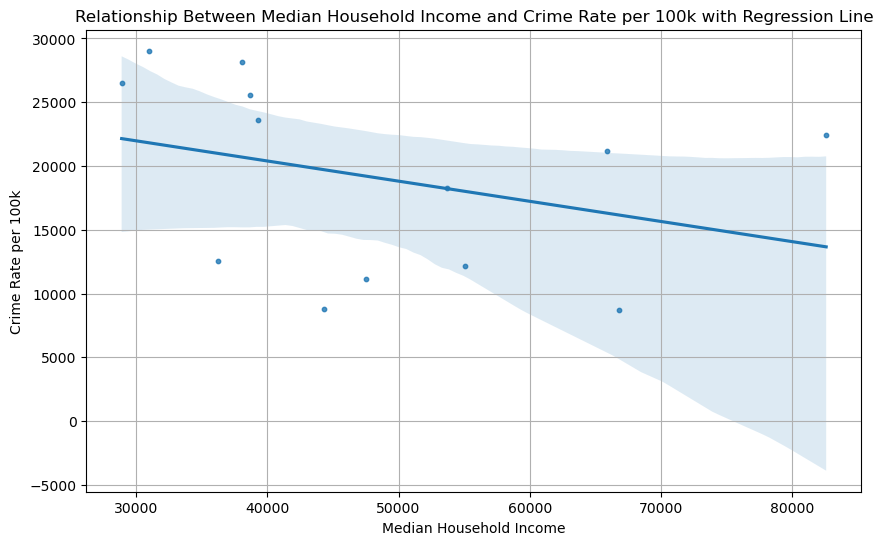

In [6]:
# load income data 
income = pd.read_csv("data\\Median_Household_Income_by_Council_Districts.csv")

# Keep only 'council_district' and 'value', and rename 'value' to 'income'
income = income[['council_district', 'value']].rename(columns={'value': 'Median Household Income'})

# Merge the 'value' column from 'income' into 'p_merged_data'
#changing data type first
p_merged_data['council_district'] = pd.to_numeric(p_merged_data['council_district'], errors='coerce')
income['council_district'] = pd.to_numeric(income['council_district'], errors='coerce')

merged_data = pd.merge(p_merged_data, income[['council_district', 'Median Household Income']], on='council_district', how='left')

# Drop rows where either 'Median Household Income' or 'Crime_Rate_Per_100k' is NaN
merged_data = merged_data.dropna(subset=['Median Household Income', 'Crime_Rate_Per_100k'])


# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_data, x='Median Household Income', y='Crime_Rate_Per_100k', scatter_kws={'s': 10})

# Adding titles and labels
plt.title('Relationship Between Median Household Income and Crime Rate per 100k with Regression Line')
plt.xlabel('Median Household Income')
plt.ylabel('Crime Rate per 100k')
plt.grid(True)
plt.show()

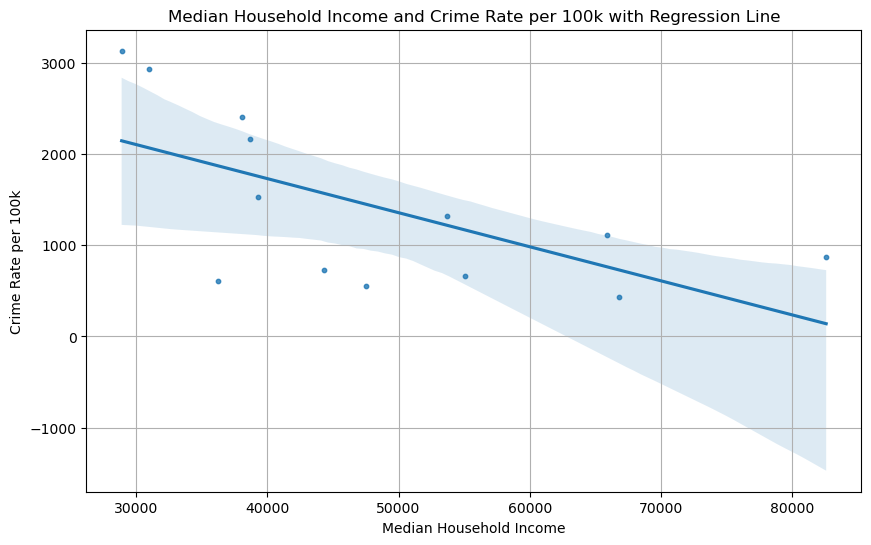

In [7]:
# We try to discover the relation between income and specific crime 
# Filter the data for rows where 'Crm Cd Desc' is 'AGGRAVATED ASSAULT'
agg_assault_data = merged_data_districts[merged_data_districts['Crm Cd Desc'] == 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT']

# Group by 'District', count the occurrences, and reset the index
agg_assault_counts = agg_assault_data.groupby('District').size().reset_index(name='Agg_Assault_Count')

# merge agg_assault_counts to our merged_data
merged_data = merged_data.merge(agg_assault_counts, left_on='council_district', right_on='District', how='left')

# normalised with population 
merged_data['Agg_Assault_Rate_Per_100k'] = (merged_data['Agg_Assault_Count'] / p_merged_data['value']) * 100000
# plotting 
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_data, x='Median Household Income', y='Agg_Assault_Rate_Per_100k', scatter_kws={'s': 10})

# Adding titles and labels
plt.title('Median Household Income and Crime Rate per 100k with Regression Line')
plt.xlabel('Median Household Income')
plt.ylabel('Crime Rate per 100k')
plt.grid(True)
plt.show()

### Q2: Are certain minority groups prone to victims of some crimes?

In [8]:
# first categorize different age groups into 5 groups  
def categorize_age(age):
    if age <= 12:
        return 'children'
    elif age <= 17:
        return 'teens'
    elif age <= 24:
        return 'young adults'
    elif age <= 64:
        return 'adults'
    else:
        return 'seniors'
# map the groupping to data
df['Age Group'] = df['Vict Age'].apply(categorize_age)

# count crimes within each age group
age_group_counts = df['Age Group'].value_counts()

<Figure size 2000x600 with 0 Axes>

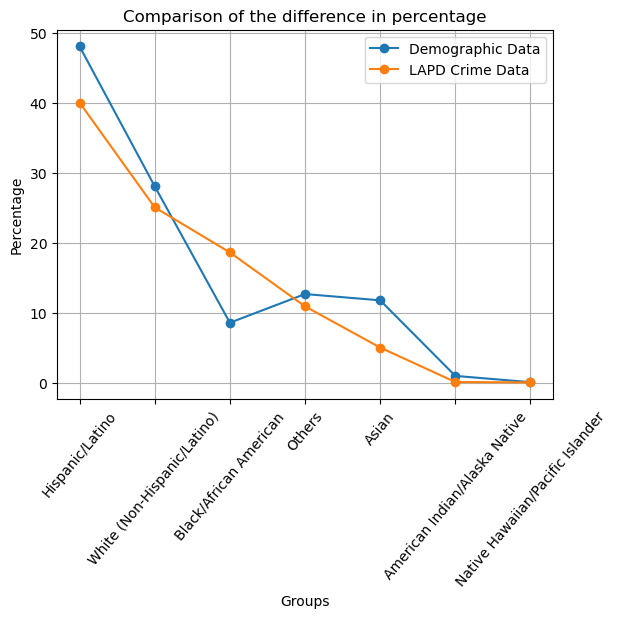

In [9]:
# Mapping dictionary for each ethnic groups
descent_mapping = {
    'A': 'Other Asian',
    'B': 'Black',
    'C': 'Chinese',
    'D': 'Cambodian',
    'F': 'Filipino',
    'G': 'Guamanian',
    'H': 'Hispanic',
    'I': 'American Indian/Alaskan Native',
    'J': 'Japanese',
    'K': 'Korean',
    'L': 'Laotian',
    'O': 'Other',
    'P': 'Pacific Islander',
    'S': 'Samoan',
    'U': 'Hawaiian',
    'V': 'Vietnamese',
    'W': 'White',
    'X': 'Unknown',
    'Z': 'Asian Indian'}

# Apply the mapping
df['Vict Descent Descriptive'] = df['Vict Descent'].map(descent_mapping)
# mapping each ethnic groups into a broader definition
descent_mapping = {
    'B': 'Black/African American',
    'I': 'American Indian/Alaska Native',
    'A': 'Asian',
    'C': 'Asian',
    'D': 'Asian',
    'F': 'Asian',
    'J': 'Asian',
    'K': 'Asian',
    'L': 'Asian',
    'V': 'Asian',
    'Z': 'Asian',
    'G': 'Native Hawaiian/Pacific Islander',
    'P': 'Native Hawaiian/Pacific Islander',
    'S': 'Native Hawaiian/Pacific Islander',
    'U': 'Native Hawaiian/Pacific Islander',
    'O': 'Others',
    'X': 'Others',
    'H': 'Hispanic/Latino',
    'W': 'White (Non-Hispanic/Latino)'
}

# Assigning the main group to a new column
df['Vict Descent Descriptive'] = df['Vict Descent'].map(descent_mapping)

vict_descent_des = df['Vict Descent Descriptive'].value_counts() 

group_counts = df['Vict Descent Descriptive'].value_counts(normalize=True) * 100  # Convert to percentages

# adding Demographic data percentages
demographic_data = {
    'Black/African American': 8.6,
    'American Indian/Alaska Native': 1.0,
    'Asian': 11.8,
    'Native Hawaiian/Pacific Islander': 0.1,
    'Others': 12.7,
    'Hispanic/Latino': 48.1,
    'White (Non-Hispanic/Latino)': 28.1
}

# Create a dataframe for plotting
plot_data = pd.DataFrame({
    'Demographic Data': demographic_data,
    'LAPD Crime Data': group_counts
}).sort_index()

# Sorting the DataFrame based on 'LAPD Crime Data' in descending order
sorted_plot_data = plot_data.sort_values(by='LAPD Crime Data', ascending=False)

# Plotting
plt.figure(figsize=(20, 6))
sorted_plot_data.plot(kind='line', marker='o')
plt.title('Comparison of the difference in percentage')
plt.ylabel('Percentage')
plt.xlabel('Groups')
plt.xticks(rotation=50)
plt.grid(True)
plt.show()


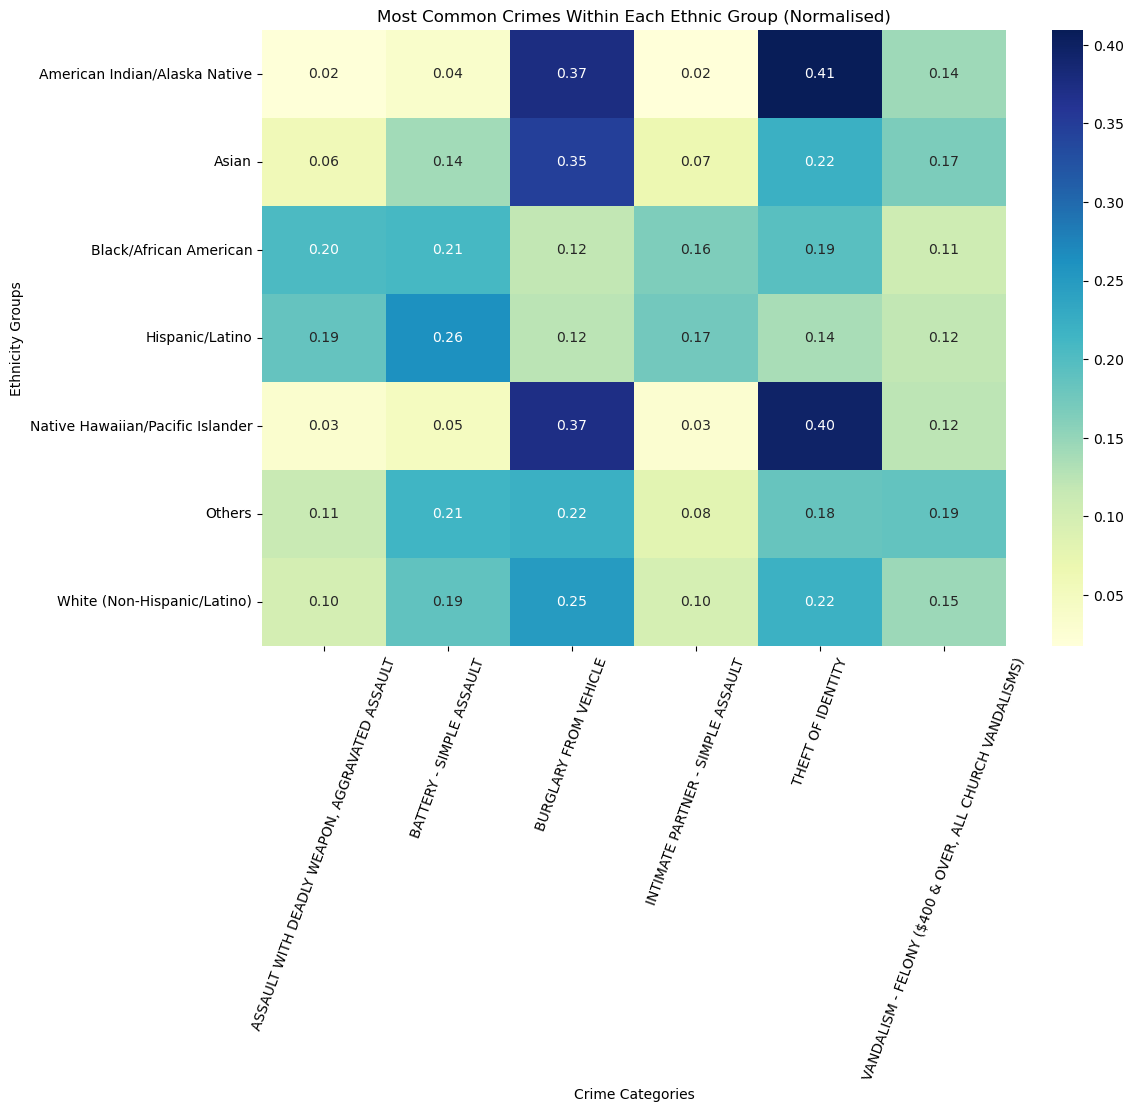

In [10]:
# We try to find the relationshop between the 6 most common crimes and each ethnic group 

# Filtering the DataFrame based on crime categories and ethnic groups
ethnic_groups = [
    'Black/African American',
    'American Indian/Alaska Native',
    'Asian',
    'Native Hawaiian/Pacific Islander',
    'Others',
    'Hispanic/Latino',
    'White (Non-Hispanic/Latino)']

crime_categories = ['BATTERY - SIMPLE ASSAULT', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 'INTIMATE PARTNER - SIMPLE ASSAULT','THEFT OF IDENTITY', 'BURGLARY FROM VEHICLE', 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)'] 
filtered_df = df[df['Crm Cd Desc'].isin(crime_categories) & df['Vict Descent Descriptive'].isin(ethnic_groups)]

pivot_table_counts = filtered_df.pivot_table(index='Vict Descent Descriptive', columns='Crm Cd Desc', aggfunc='size', fill_value=0)


# now we try to use the population of each group as weight to normalise the crime rate
weight = {
    'Black/African American': 8.6,
    'American Indian/Alaska Native': 1.0,
    'Asian': 11.8,
    'Native Hawaiian/Pacific Islander': 0.1,
    'Others': 12.7,
    'Hispanic/Latino': 48.1,
    'White (Non-Hispanic/Latino)': 28.1
}

filtered_df = df[df['Crm Cd Desc'].isin(crime_categories) & df['Vict Descent Descriptive'].isin(ethnic_groups)].copy()
filtered_df['Weight'] = filtered_df['Vict Descent Descriptive'].map(weight)


# Grouping the data by 'Vict Descent Descriptive' and 'Crm Cd Desc' and summing the weights
grouped_data_with_provided_weight = filtered_df.groupby(['Vict Descent Descriptive', 'Crm Cd Desc'])['Weight'].sum().reset_index()


# Creating a pivot table with the sum of weights
pivot_table_provided_weights = grouped_data_with_provided_weight.pivot_table(index='Vict Descent Descriptive', columns='Crm Cd Desc', values='Weight', aggfunc='sum', 
fill_value=0)


# Normalizing the pivot table by dividing each cell by the sum of weights for each ethnic group
normalized_pivot_table_provided = pivot_table_provided_weights.div(pivot_table_provided_weights.sum(axis=1), axis=0)

# Plotting the normalized heatmap with provided weights
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_pivot_table_provided, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Most Common Crimes Within Each Ethnic Group (Normalised)')
plt.xlabel('Crime Categories')
plt.xticks(rotation=70)
plt.ylabel('Ethnicity Groups')
plt.show()

### Complex Hypotheses - Findings / Insights:

We examine the relationship between income levels and crime rates. Our analysis reveals no significant negative correlation between income levels and overall crime rates across various districts. However, when we narrow down on a specific crime category, 'assault with deadly weapon, aggravated assault', a distinct negative correlation emerges. This finding indicates that districts with higher income levels tend to have lower incidences of aggravated assault. Regarding the impact on various ethnic groups, our data shows that Black/African American individuals disproportionately represent a larger percentage of victims relative to their population proportion. 
Consequently, we delve deeper to identify the six most common types of crimes and their prevalence among different ethnic groups. Surprisingly, we discover that American Indian/Alaska Native individuals have the highest victimization rate for identity theft, a finding that worth further investigating



---
## Black Hat Visualization

**Instructions:**
- Add your black hat visualization
- Add a description explaining your motivation and design process in producing this visualization (**max. 150 words**)

#### Visualization

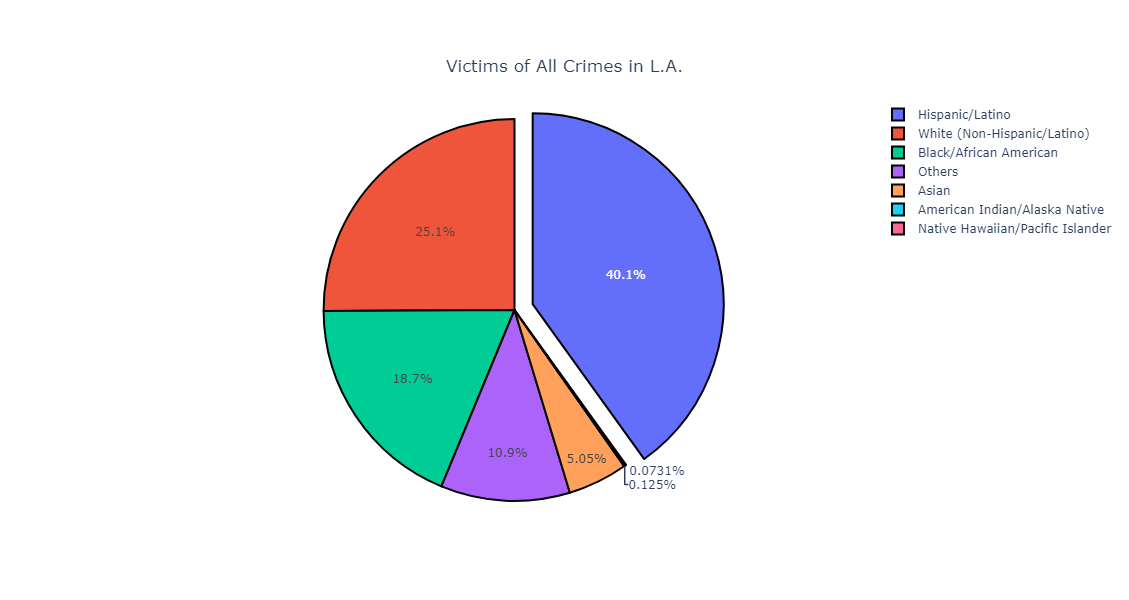

In [13]:
import plotly.graph_objects as go

vict_descent_des = df['Vict Descent Descriptive'].value_counts()

# Identify the index of the largest slice
largest_index = vict_descent_des.idxmax()

# Initialize pull list with all zeros
pull_values = [0] * len(vict_descent_des)

# Pull out the largest slice
pull_values[vict_descent_des.index.get_loc(largest_index)] = 0.1

# Create the data for the plot
data = go.Pie(labels=vict_descent_des.index, values=vict_descent_des, pull=pull_values)

# Create the figure with the data
fig = go.Figure(data=[data])

# Set the title of the plot and adjust its position
fig.update_layout(title={
                        'text': "Victims of All Crimes in L.A.",
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'
                    },
                  # Make the plot bigger
                  autosize=False,
                  width=800,
                  height=600)

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.show()


#due to the fact its an interactive plot 
from IPython.display import Image

# we insert the screenshot of the plot
Image(url='https://raw.githubusercontent.com/jku-icg-classroom/va-group-project-cyan-crabs/master/screenshot/black%20hat.png?token=GHSAT0AAAAAACM7CCK4HG2M7KRXD2375RDCZNJWJAA')



#### Description

This black hat visualization misleads readers into thinking that Hispanic/Latino people are more prone to being victims of all crime types in Los Angeles City. However, this is a false statement. For those unfamiliar with the demographics of L.A., it might be surprising to learn that the Hispanic/Latino population constitutes 48.1% of the total population. With this in mind, the victimization rate for Hispanic or Latino individuals is actually lower.